In [3]:
import numpy
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import normalized_mutual_info_score
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import torch.nn.functional as F
from scipy.optimize import linear_sum_assignment
from clustpy.deep import FlexibleAutoencoder, DCN, IDEC
from kmodes.kprototypes import KPrototypes

from duped_modules.dcn_duped import DCN as DCNDuped
from duped_modules.embeddings_autoencoder import EmbeddingsAutoencoder
from duped_modules.gower_duped import gower_matrix as gower_matrix_duped

,age,job,marital,education,default,balance,housing,loan,contact,duration,campaign,pdays,previous,poutcome
0,12,10,1,0,0,0.139496,0,0,0,-0.695712,-0.569351,-0.411453,-0.251940,3
1,15,7,1,1,0,1.125461,1,1,0,-0.148192,-0.569351,2.984213,1.484611,0
2,17,4,2,2,0,-0.004031,1,0,0,-0.284101,-0.569351,2.894327,0.182198,0
3,12,4,1,2,0,0.037352,1,1,2,-0.229737,0.399020,-0.411453,-0.251940,3
4,41,1,1,1,0,-0.447419,1,0,2,-0.124893,-0.569351,-0.411453,-0.251940,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49727,33,9,1,2,0,-0.176460,0,0,0,2.791329,0.076230,-0.411453,-0.251940,3
49728,53,5,0,0,0,0.120447,0,0,0,0.768224,-0.246560,-0.411453,-0.251940,3
49729,54,5,1,1,0,1.429593,0,0,0,3.373797,0.721811,1.436189,1.050473,2
49730,39,1,1,1,0,-0.228024,0,0,1,0.970146,0.399020,-0.411453,-0.251940,3


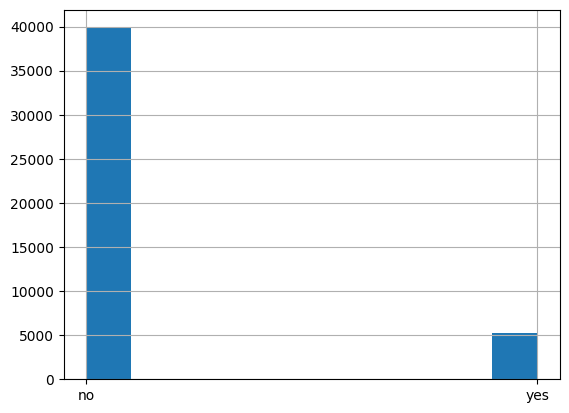

In [2]:
banking_df = pd.read_csv("datasets/banking_marketing.csv", sep=";")
banking_df.drop_duplicates(inplace=True)

banking_y = banking_df["y"]
banking_y.hist()
banking_y = LabelEncoder().fit_transform(banking_y)

banking_cat_cols = ["age", "job", "marital", "education", "default", "housing", "loan", "contact", "poutcome"]
banking_cont_cols = ["balance", "duration", "campaign", "pdays", "previous"]

banking_df.drop(columns=["y", "day", "month"], axis=1, inplace=True)
banking_df[banking_cat_cols] = banking_df[banking_cat_cols].apply(LabelEncoder().fit_transform)
banking_df[banking_cont_cols] = StandardScaler().fit_transform(banking_df[banking_cont_cols])
banking_df

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,0.025724,7,-1.061993,9,1.136595,4,1,1,4,1,0.146804,-0.217195,-0.034304,39
1,0.828125,6,-1.007118,9,1.136595,2,4,0,4,1,-0.144847,-0.217195,-2.213335,39
2,-0.047221,4,0.245993,11,-0.419685,0,6,1,4,1,-0.144847,-0.217195,-0.034304,39
3,1.046961,4,0.426618,1,-1.197826,2,6,0,2,1,-0.144847,-0.217195,-0.034304,39
4,-0.776676,4,1.408464,9,1.136595,2,10,5,2,0,-0.144847,-0.217195,-0.034304,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48837,0.025724,4,0.243843,9,1.136595,0,10,1,4,0,-0.144847,-0.217195,-0.357123,39
48838,1.849362,0,1.247430,11,-0.419685,6,0,2,2,1,-0.144847,-0.217195,-0.034304,39
48839,-0.047221,4,1.754792,9,1.136595,2,10,0,4,1,-0.144847,-0.217195,0.772745,39
48840,0.390452,4,-1.001626,9,1.136595,0,1,3,1,1,0.586964,-0.217195,-0.034304,39


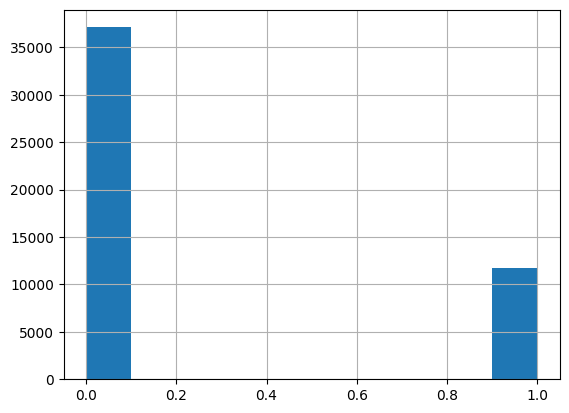

In [3]:
census_df = pd.read_csv("datasets/census_income.csv")
census_df.drop_duplicates(inplace=True)

census_df.loc[(census_df["class"] == " <=50K.") | (census_df["class"] == " <=50K"), "class"] = 0
census_df.loc[(census_df["class"] == " >50K.") | (census_df["class"] == " >50K"), "class"] = 1
census_df["class"].hist()
census_y = census_df["class"].to_numpy()

census_cat_cols = ["workclass", "education", "marital-status", "occupation", "relationship", "race", "sex", "native-country"]
census_cont_cols = ["age", "fnlwgt", "education-num", "capital-gain", "capital-loss", "hours-per-week"]

census_df.drop(columns="class", inplace=True)
census_df[census_cat_cols] = census_df[census_cat_cols].apply(LabelEncoder().fit_transform)
census_df[census_cont_cols] = StandardScaler().fit_transform(census_df[census_cont_cols])
census_df

,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12,A13,A14,A15
0,1,-0.056962,-0.961440,1,0,12,7,-0.295171,1,1,-0.302596,0,0,0.128682,-0.193125
1,0,2.296536,-0.073565,1,0,10,3,0.236217,1,1,0.704516,0,0,-0.816802,-0.086443
2,0,-0.592078,-0.861903,1,0,10,3,-0.220955,1,0,-0.504019,0,0,0.592504,-0.036150
3,1,-0.310572,-0.654865,1,0,12,7,0.446990,1,1,0.503093,1,0,-0.477855,-0.192553
4,1,-0.958122,0.158358,1,0,12,7,-0.158613,1,0,-0.504019,0,2,-0.358926,-0.193125
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
685,1,-0.881193,1.046233,2,2,4,3,-0.295171,0,0,-0.504019,0,0,0.473575,-0.193125
686,0,-0.746780,-0.812134,1,0,1,7,-0.072523,0,1,-0.101174,1,0,0.116789,-0.118066
687,0,-0.528676,1.726075,2,2,5,2,-0.072523,0,1,-0.302596,1,0,0.116789,-0.192934
688,1,-1.148329,-0.920630,1,0,0,7,-0.654378,0,0,-0.504019,0,0,0.592504,-0.050247


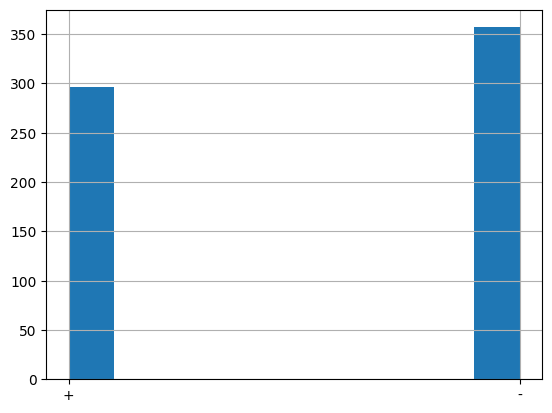

In [4]:
credit_df = pd.read_csv("datasets/credit_approval.csv")
credit_df.replace("?", pd.NA, inplace=True)
credit_df.dropna(inplace=True)
credit_df.drop_duplicates(inplace=True)

credit_y = credit_df["A16"]
credit_y.hist()
credit_y = LabelEncoder().fit_transform(credit_y)

credit_cat_cols = ["A1", "A4", "A5", "A6", "A7", "A9", "A10", "A12", "A13"]
credit_cont_cols = ["A2", "A3", "A8", "A11", "A14", "A15"]

credit_df.drop(columns="A16", inplace=True)
credit_df[credit_cat_cols] = credit_df[credit_cat_cols].apply(LabelEncoder().fit_transform)
credit_df[credit_cont_cols] = StandardScaler().fit_transform(credit_df[credit_cont_cols])
credit_df

,age,sex,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,ca,thal
0,0.940446,1,3,0.749760,-0.262867,1,0,0.029124,0,1.069475,0,-0.718306,0
1,1.384143,1,0,1.596354,0.747722,0,0,-1.790447,1,0.380309,1,2.487269,1
2,1.384143,1,0,-0.661231,-0.339138,0,0,-0.880662,1,1.327912,1,1.418744,2
3,-1.943588,1,2,-0.096835,0.061285,0,1,1.632079,0,2.103224,0,-0.718306,1
4,-1.499891,0,1,-0.096835,-0.815830,0,0,0.982232,0,0.294163,2,-0.718306,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
299,1.495068,1,0,0.693320,-1.025575,1,1,-0.360784,0,2.017078,1,1.418744,2
300,0.274900,1,0,-0.096835,-2.207774,0,1,-1.487186,1,0.121872,1,0.350219,2
301,0.274900,0,1,-0.096835,-0.205664,0,0,1.068878,0,-0.911877,1,0.350219,1
508,-0.834344,1,0,1.031958,-0.396341,0,1,-2.223678,1,0.380309,1,-0.718306,2


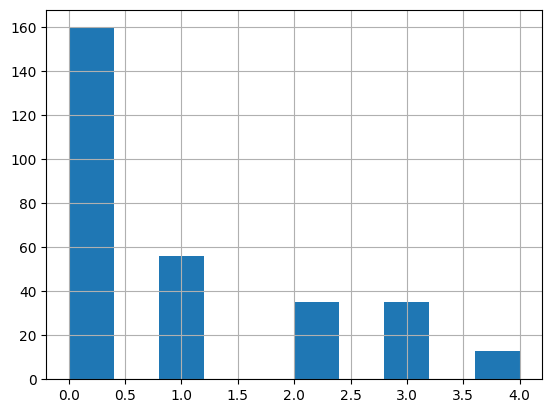

In [5]:
heart_df = pd.read_csv("datasets/heart_disease.csv")
heart_df.dropna(inplace=True)
heart_df.drop_duplicates(inplace=True)

heart_df["num"].hist()
heart_y = heart_df["num"].to_numpy()

heart_cat_cols = ["sex", "cp", "fbs", "restecg", "exang", "slope", "thal"]
heart_cont_cols = ["age", "trestbps", "chol", "thalch", "oldpeak", "ca"]

heart_df.drop(columns=["id", "dataset", "num"], inplace=True)
heart_df.dropna(inplace=True)

heart_df[heart_cat_cols] = heart_df[heart_cat_cols].apply(LabelEncoder().fit_transform)
heart_df[heart_cont_cols] = StandardScaler().fit_transform(heart_df[heart_cont_cols])
heart_df

In [6]:
class BankingDataset(Dataset):
    def __init__(self, df):
        self.cat = torch.tensor(df[banking_cat_cols].values, dtype=torch.float)
        self.cont = torch.tensor(df[banking_cont_cols].values, dtype=torch.float)
    def __getitem__(self, idx):
        return self.cat[idx], self.cont[idx]
    def __len__(self):
        return self.cat.shape[0]

banking_dataloader = DataLoader(BankingDataset(banking_df), batch_size=512, shuffle=True)

banking_emb_sizes = [(banking_df[col].nunique(), min(50, banking_df[col].nunique()+1) // 2) for col in banking_df[banking_cat_cols]]
banking_cat_dim = sum(d for _, d in banking_emb_sizes)
banking_input_dim = banking_cat_dim + len(banking_cont_cols)

print(f"Cat dim: {banking_cat_dim}, Input dim: {banking_input_dim}")
print(f"Embeddings: {banking_emb_sizes}")

Cat dim: 42, Input dim: 47
Embeddings: [(77, 25), (12, 6), (3, 2), (4, 2), (2, 1), (2, 1), (2, 1), (3, 2), (4, 2)]


In [7]:
class CensusDataset(Dataset):
    def __init__(self, df):
        self.cat = torch.tensor(df[census_cat_cols].values, dtype=torch.float)
        self.cont = torch.tensor(df[census_cont_cols].values, dtype=torch.float)
    def __getitem__(self, idx):
        return self.cat[idx], self.cont[idx]
    def __len__(self):
        return self.cat.shape[0]

census_dataloader = DataLoader(CensusDataset(census_df), batch_size=512, shuffle=True)

census_emb_sizes = [(census_df[col].nunique(), min(50, census_df[col].nunique() + 1) // 2) for col in census_df[census_cat_cols]]
census_cat_dim = sum(d for _, d in census_emb_sizes)
census_input_dim = census_cat_dim + len(census_cont_cols)

print(f"Cat dim: {census_cat_dim}, Input dim: {census_input_dim}")
print(f"Embeddings: {census_emb_sizes}")

Cat dim: 53, Input dim: 59
Embeddings: [(9, 5), (16, 8), (7, 4), (15, 8), (6, 3), (5, 3), (2, 1), (42, 21)]


In [8]:
class CreditDataset(Dataset):
    def __init__(self, df):
        self.cat = torch.tensor(df[credit_cat_cols].values, dtype=torch.float)
        self.cont = torch.tensor(df[credit_cont_cols].values, dtype=torch.float)
    def __getitem__(self, idx):
        return self.cat[idx], self.cont[idx]
    def __len__(self):
        return self.cat.shape[0]

credit_dataloader = DataLoader(CreditDataset(credit_df), batch_size=32, shuffle=True)

credit_emb_sizes = [(credit_df[col].nunique(), min(50, credit_df[col].nunique() + 1) // 2) for col in credit_df[credit_cat_cols]]
credit_cat_dim = sum(d for _, d in credit_emb_sizes)
credit_input_dim = credit_cat_dim + len(credit_cont_cols)

print(f"Cat dim: {credit_cat_dim}, Input dim: {credit_input_dim}")
print(f"Embeddings: {credit_emb_sizes}")

Cat dim: 22, Input dim: 28
Embeddings: [(2, 1), (3, 2), (3, 2), (14, 7), (9, 5), (2, 1), (2, 1), (2, 1), (3, 2)]


In [9]:
class HeartDataset(Dataset):
    def __init__(self, df):
        self.cat = torch.tensor(df[heart_cat_cols].values, dtype=torch.float)
        self.cont = torch.tensor(df[heart_cont_cols].values, dtype=torch.float)
    def __getitem__(self, idx):
        return self.cat[idx], self.cont[idx]
    def __len__(self):
        return self.cat.shape[0]

heart_dataloader = DataLoader(HeartDataset(heart_df), batch_size=64, shuffle=True)

heart_emb_sizes = [(heart_df[col].nunique(), min(50, heart_df[col].nunique() + 1) // 2) for col in heart_df[heart_cat_cols]]
heart_cat_dim = sum(d for n, d in heart_emb_sizes)
heart_input_dim = heart_cat_dim + len(heart_cont_cols)

print(f"Cat dim: {heart_cat_dim}, Input dim: {heart_input_dim}")
print(f"Embeddings: {heart_emb_sizes}")

Cat dim: 11, Input dim: 17
Embeddings: [(2, 1), (4, 2), (2, 1), (3, 2), (2, 1), (3, 2), (3, 2)]


In [10]:
banking_k_prototypes = KPrototypes(n_clusters=2, random_state=0)
banking_k_prototypes.fit(banking_df.values, categorical=[banking_df.columns.get_loc(col) for col in banking_cat_cols])
banking_k_prototypes_nmi = normalized_mutual_info_score(banking_y, banking_k_prototypes.labels_)
banking_k_prototypes_nmi

0.017825373955683156

In [11]:
census_k_prototypes = KPrototypes(n_clusters=2, random_state=0)
census_k_prototypes.fit(census_df.values, categorical=[census_df.columns.get_loc(col) for col in census_cat_cols])
census_k_prototypes_nmi = normalized_mutual_info_score(census_y, census_k_prototypes.labels_)
census_k_prototypes_nmi

0.0224625641297901

In [12]:
credit_k_prototypes = KPrototypes(n_clusters=2, random_state=0)
credit_k_prototypes.fit(credit_df.values, categorical=[credit_df.columns.get_loc(col) for col in credit_cat_cols])
credit_k_prototypes_nmi = normalized_mutual_info_score(credit_y, credit_k_prototypes.labels_)
credit_k_prototypes_nmi

0.10895828404430437

In [13]:
heart_k_prototypes = KPrototypes(n_clusters=5, random_state=0)
heart_k_prototypes.fit(heart_df.values, categorical=[heart_df.columns.get_loc(col) for col in heart_cat_cols])
heart_k_prototypes_nmi = normalized_mutual_info_score(heart_y, heart_k_prototypes.labels_)
heart_k_prototypes_nmi

0.17059947018933327

In [14]:
banking_encoder = torch.nn.Sequential(
    torch.nn.Linear(banking_input_dim, 32),
    torch.nn.BatchNorm1d(32),
    torch.nn.ReLU(),
    torch.nn.Linear(32, 16),
    torch.nn.BatchNorm1d(16),
    torch.nn.ReLU(),
    torch.nn.Linear(16, 8),
    torch.nn.BatchNorm1d(8),
    torch.nn.Sigmoid(),
)
banking_decoder = torch.nn.Sequential(
    torch.nn.Linear(8, 16),
    torch.nn.ReLU(),
    torch.nn.Linear(16, 32),
    torch.nn.ReLU(),
    torch.nn.Linear(32, banking_cat_dim),
    torch.nn.Sigmoid()
)
banking_ae = EmbeddingsAutoencoder(banking_encoder, banking_decoder, banking_input_dim, banking_cat_dim, banking_emb_sizes, attention=False)
banking_ae.fit(n_epochs=100, lr=0.001, dataloader=banking_dataloader)

banking_attention_ae = EmbeddingsAutoencoder(banking_encoder, banking_decoder, banking_input_dim, banking_cat_dim, banking_emb_sizes, attention=True)
banking_attention_ae.fit(n_epochs=100, lr=0.001, dataloader=banking_dataloader)

cat = torch.tensor(banking_df[banking_cat_cols].values, dtype=torch.float)
cont = torch.tensor(banking_df[banking_cont_cols].values, dtype=torch.float)
cat_features = banking_ae.encode(cat, cont).detach().numpy()
features = np.concatenate((cat_features, banking_df[banking_cont_cols].values), 1)
kmeans = KMeans(n_clusters=2, n_init="auto", random_state=0).fit(features)
banking_ae_nmi = normalized_mutual_info_score(banking_y, kmeans.labels_)
print(banking_ae_nmi)

cat = torch.tensor(banking_df[banking_cat_cols].values, dtype=torch.float)
cont = torch.tensor(banking_df[banking_cont_cols].values, dtype=torch.float)
cat_features = banking_ae.encode(cat, cont).detach().numpy()
features = np.concatenate((cat_features, banking_df[banking_cont_cols].values), 1)
kmeans = KMeans(n_clusters=2, n_init="auto", random_state=0).fit(features)
banking_attention_ae_nmi = normalized_mutual_info_score(banking_y, kmeans.labels_)
print(banking_attention_ae_nmi)

Epoch 1/100 - Batch Reconstruction loss: 0.930476
Epoch 2/100 - Batch Reconstruction loss: 0.917260
Epoch 3/100 - Batch Reconstruction loss: 0.865128
Epoch 4/100 - Batch Reconstruction loss: 0.819690
Epoch 5/100 - Batch Reconstruction loss: 0.826870
Epoch 6/100 - Batch Reconstruction loss: 0.786528
Epoch 7/100 - Batch Reconstruction loss: 0.781673
Epoch 8/100 - Batch Reconstruction loss: 0.756404
Epoch 9/100 - Batch Reconstruction loss: 0.753406
Epoch 10/100 - Batch Reconstruction loss: 0.746056
Epoch 11/100 - Batch Reconstruction loss: 0.716484
Epoch 12/100 - Batch Reconstruction loss: 0.700198
Epoch 13/100 - Batch Reconstruction loss: 0.680214
Epoch 14/100 - Batch Reconstruction loss: 0.679952
Epoch 15/100 - Batch Reconstruction loss: 0.694180
Epoch 16/100 - Batch Reconstruction loss: 0.694416
Epoch 17/100 - Batch Reconstruction loss: 0.676520
Epoch 18/100 - Batch Reconstruction loss: 0.665974
Epoch 19/100 - Batch Reconstruction loss: 0.684644
Epoch 20/100 - Batch Reconstruction loss

In [15]:
census_encoder = torch.nn.Sequential(
    torch.nn.Linear(census_input_dim, 32),
    torch.nn.BatchNorm1d(32),
    torch.nn.ReLU(),
    torch.nn.Linear(32, 16),
    torch.nn.BatchNorm1d(16),
    torch.nn.ReLU(),
    torch.nn.Linear(16, 8),
    torch.nn.BatchNorm1d(8),
    torch.nn.Sigmoid(),
)
census_decoder = torch.nn.Sequential(
    torch.nn.Linear(8, 16),
    torch.nn.ReLU(),
    torch.nn.Linear(16, 32),
    torch.nn.ReLU(),
    torch.nn.Linear(32, census_cat_dim),
    torch.nn.Sigmoid()
)
census_ae = EmbeddingsAutoencoder(census_encoder, census_decoder, census_input_dim, census_cat_dim, census_emb_sizes, attention=False)
census_ae.fit(n_epochs=100, lr=0.001, dataloader=census_dataloader)

census_attention_ae = EmbeddingsAutoencoder(census_encoder, census_decoder, census_input_dim, census_cat_dim, census_emb_sizes, attention=True)
census_attention_ae.fit(n_epochs=100, lr=0.001, dataloader=census_dataloader)

cat = torch.tensor(census_df[census_cat_cols].values, dtype=torch.float)
cont = torch.tensor(census_df[census_cont_cols].values, dtype=torch.float)
cat_features = census_ae.encode(cat, cont).detach().numpy()
features = np.concatenate((cat_features, census_df[census_cont_cols].values), 1)
kmeans = KMeans(n_clusters=2, n_init="auto", random_state=0).fit(features)
census_ae_nmi = normalized_mutual_info_score(census_y, kmeans.labels_)
print(census_ae_nmi)

cat = torch.tensor(census_df[census_cat_cols].values, dtype=torch.float)
cont = torch.tensor(census_df[census_cont_cols].values, dtype=torch.float)
cat_features = census_ae.encode(cat, cont).detach().numpy()
features = np.concatenate((cat_features, census_df[census_cont_cols].values), 1)
kmeans = KMeans(n_clusters=2, n_init="auto", random_state=0).fit(features)
census_attention_ae_nmi = normalized_mutual_info_score(census_y, kmeans.labels_)
print(census_attention_ae_nmi)

Epoch 1/100 - Batch Reconstruction loss: 0.822098
Epoch 2/100 - Batch Reconstruction loss: 0.749731
Epoch 3/100 - Batch Reconstruction loss: 0.694711
Epoch 4/100 - Batch Reconstruction loss: 0.683287
Epoch 5/100 - Batch Reconstruction loss: 0.649575
Epoch 6/100 - Batch Reconstruction loss: 0.641546
Epoch 7/100 - Batch Reconstruction loss: 0.628658
Epoch 8/100 - Batch Reconstruction loss: 0.619856
Epoch 9/100 - Batch Reconstruction loss: 0.582192
Epoch 10/100 - Batch Reconstruction loss: 0.603957
Epoch 11/100 - Batch Reconstruction loss: 0.583587
Epoch 12/100 - Batch Reconstruction loss: 0.577979
Epoch 13/100 - Batch Reconstruction loss: 0.596995
Epoch 14/100 - Batch Reconstruction loss: 0.579653
Epoch 15/100 - Batch Reconstruction loss: 0.568453
Epoch 16/100 - Batch Reconstruction loss: 0.556086
Epoch 17/100 - Batch Reconstruction loss: 0.553962
Epoch 18/100 - Batch Reconstruction loss: 0.558708
Epoch 19/100 - Batch Reconstruction loss: 0.544426
Epoch 20/100 - Batch Reconstruction loss

In [16]:
credit_encoder = torch.nn.Sequential(
    torch.nn.Linear(credit_input_dim, 16),
    torch.nn.BatchNorm1d(16),
    torch.nn.ReLU(),
    torch.nn.Linear(16, 8),
    torch.nn.BatchNorm1d(8),
    torch.nn.Sigmoid(),
    torch.nn.Linear(8, 4),
    torch.nn.BatchNorm1d(4),
    torch.nn.Sigmoid(),
)
credit_decoder = torch.nn.Sequential(
    torch.nn.Linear(4, 8),
    torch.nn.ReLU(),
    torch.nn.Linear(8, 16),
    torch.nn.ReLU(),
    torch.nn.Linear(16, credit_cat_dim),
    torch.nn.Sigmoid()
)
credit_ae = EmbeddingsAutoencoder(credit_encoder, credit_decoder, credit_input_dim, credit_cat_dim, credit_emb_sizes, attention=False)
credit_ae.fit(n_epochs=100, lr=0.001, dataloader=credit_dataloader)

credit_attention_ae = EmbeddingsAutoencoder(credit_encoder, credit_decoder, credit_input_dim, credit_cat_dim, credit_emb_sizes, attention=True)
credit_attention_ae.fit(n_epochs=100, lr=0.001, dataloader=credit_dataloader)

cat = torch.tensor(credit_df[credit_cat_cols].values, dtype=torch.float)
cont = torch.tensor(credit_df[credit_cont_cols].values, dtype=torch.float)
cat_features = credit_ae.encode(cat, cont).detach().numpy()
features = np.concatenate((cat_features, credit_df[credit_cont_cols].values), 1)
kmeans = KMeans(n_clusters=2, n_init="auto", random_state=0).fit(features)
credit_ae_nmi = normalized_mutual_info_score(credit_y, kmeans.labels_)
print(credit_ae_nmi)

cat = torch.tensor(credit_df[credit_cat_cols].values, dtype=torch.float)
cont = torch.tensor(credit_df[credit_cont_cols].values, dtype=torch.float)
cat_features = credit_ae.encode(cat, cont).detach().numpy()
features = np.concatenate((cat_features, credit_df[credit_cont_cols].values), 1)
kmeans = KMeans(n_clusters=2, n_init="auto", random_state=0).fit(features)
credit_attention_ae_nmi = normalized_mutual_info_score(credit_y, kmeans.labels_)
print(credit_attention_ae_nmi)

Epoch 1/100 - Batch Reconstruction loss: 0.693568
Epoch 2/100 - Batch Reconstruction loss: 0.746958
Epoch 3/100 - Batch Reconstruction loss: 0.639393
Epoch 4/100 - Batch Reconstruction loss: 0.564254
Epoch 5/100 - Batch Reconstruction loss: 0.605934
Epoch 6/100 - Batch Reconstruction loss: 0.572751
Epoch 7/100 - Batch Reconstruction loss: 0.553373
Epoch 8/100 - Batch Reconstruction loss: 0.423068
Epoch 9/100 - Batch Reconstruction loss: 0.446666
Epoch 10/100 - Batch Reconstruction loss: 0.468297
Epoch 11/100 - Batch Reconstruction loss: 0.428269
Epoch 12/100 - Batch Reconstruction loss: 0.408460
Epoch 13/100 - Batch Reconstruction loss: 0.451004
Epoch 14/100 - Batch Reconstruction loss: 0.368919
Epoch 15/100 - Batch Reconstruction loss: 0.442503
Epoch 16/100 - Batch Reconstruction loss: 0.373074
Epoch 17/100 - Batch Reconstruction loss: 0.439266
Epoch 18/100 - Batch Reconstruction loss: 0.375086
Epoch 19/100 - Batch Reconstruction loss: 0.353253
Epoch 20/100 - Batch Reconstruction loss

In [17]:
heart_encoder = torch.nn.Sequential(
    torch.nn.Linear(heart_input_dim, 8),
    torch.nn.BatchNorm1d(8),
    torch.nn.ReLU(),
    torch.nn.Linear(8, 5),
    torch.nn.BatchNorm1d(5),
    torch.nn.Sigmoid(),
    torch.nn.Linear(5, 3),
    torch.nn.BatchNorm1d(3),
    torch.nn.Sigmoid(),
)
heart_decoder = torch.nn.Sequential(
    torch.nn.Linear(3, 5),
    torch.nn.ReLU(),
    torch.nn.Linear(5, 8),
    torch.nn.ReLU(),
    torch.nn.Linear(8, heart_cat_dim),
    torch.nn.Sigmoid()
)
heart_ae = EmbeddingsAutoencoder(heart_encoder, heart_decoder, heart_input_dim, heart_cat_dim, heart_emb_sizes, attention=False)
heart_ae.fit(n_epochs=100, lr=0.001, dataloader=heart_dataloader)

heart_attention_ae = EmbeddingsAutoencoder(heart_encoder, heart_decoder, heart_input_dim, heart_cat_dim, heart_emb_sizes, attention=True)
heart_attention_ae.fit(n_epochs=100, lr=0.001, dataloader=heart_dataloader)

cat = torch.tensor(heart_df[heart_cat_cols].values, dtype=torch.float)
cont = torch.tensor(heart_df[heart_cont_cols].values, dtype=torch.float)
cat_features = heart_ae.encode(cat, cont).detach().numpy()
features = np.concatenate((cat_features, heart_df[heart_cont_cols].values), 1)
kmeans = KMeans(n_clusters=5, n_init="auto", random_state=0).fit(features)
heart_ae_nmi = normalized_mutual_info_score(heart_y, kmeans.labels_)
print(heart_ae_nmi)

cat = torch.tensor(heart_df[heart_cat_cols].values, dtype=torch.float)
cont = torch.tensor(heart_df[heart_cont_cols].values, dtype=torch.float)
cat_features = heart_ae.encode(cat, cont).detach().numpy()
features = np.concatenate((cat_features, heart_df[heart_cont_cols].values), 1)
kmeans = KMeans(n_clusters=5, n_init="auto", random_state=0).fit(features)
heart_attention_ae_nmi = normalized_mutual_info_score(heart_y, kmeans.labels_)
print(heart_attention_ae_nmi)

Epoch 1/100 - Batch Reconstruction loss: 1.004110
Epoch 2/100 - Batch Reconstruction loss: 1.011177
Epoch 3/100 - Batch Reconstruction loss: 1.067677
Epoch 4/100 - Batch Reconstruction loss: 1.072329
Epoch 5/100 - Batch Reconstruction loss: 1.029546
Epoch 6/100 - Batch Reconstruction loss: 1.024902
Epoch 7/100 - Batch Reconstruction loss: 1.060408
Epoch 8/100 - Batch Reconstruction loss: 1.033805
Epoch 9/100 - Batch Reconstruction loss: 1.005136
Epoch 10/100 - Batch Reconstruction loss: 1.024001
Epoch 11/100 - Batch Reconstruction loss: 1.050861
Epoch 12/100 - Batch Reconstruction loss: 0.971308
Epoch 13/100 - Batch Reconstruction loss: 1.049785
Epoch 14/100 - Batch Reconstruction loss: 0.910415
Epoch 15/100 - Batch Reconstruction loss: 1.016182
Epoch 16/100 - Batch Reconstruction loss: 0.991272
Epoch 17/100 - Batch Reconstruction loss: 0.998470
Epoch 18/100 - Batch Reconstruction loss: 1.053283
Epoch 19/100 - Batch Reconstruction loss: 1.017823
Epoch 20/100 - Batch Reconstruction loss

In [18]:
banking_dcn = DCNDuped(n_clusters=2, pretrain_epochs=100, clustering_epochs=100, autoencoder=banking_ae, random_state=np.random.RandomState(0))
banking_dcn.fit(banking_dataloader)

banking_attention_dcn = DCNDuped(n_clusters=2, pretrain_epochs=100, clustering_epochs=100, autoencoder=banking_attention_ae, random_state=np.random.RandomState(0))
banking_attention_dcn.fit(banking_dataloader)

banking_dcn_nmi = normalized_mutual_info_score(banking_y, banking_dcn.labels_)
print(banking_dcn_nmi)

banking_attention_dcn_nmi = normalized_mutual_info_score(banking_y, banking_dcn.labels_)
print(banking_attention_dcn_nmi)

C:\Users\jaani\repos\attention-mixed-type-clustering\venv\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\jaani\repos\attention-mixed-type-clustering\venv\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\jaani\repos\attention-mixed-type-clustering\venv\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


1.1183896255679725e-07
1.1183896255679725e-07


C:\Users\jaani\repos\attention-mixed-type-clustering\venv\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [19]:
census_dcn = DCNDuped(n_clusters=2, pretrain_epochs=100, clustering_epochs=100, autoencoder=census_ae, random_state=np.random.RandomState(0))
census_dcn.fit(census_dataloader)

census_attention_dcn = DCNDuped(n_clusters=2, pretrain_epochs=100, clustering_epochs=100, autoencoder=census_attention_ae, random_state=np.random.RandomState(0))
census_attention_dcn.fit(census_dataloader)

census_dcn_nmi = normalized_mutual_info_score(census_y, census_dcn.labels_)
print(census_dcn_nmi)

census_attention_dcn_nmi = normalized_mutual_info_score(census_y, census_dcn.labels_)
print(census_attention_dcn_nmi)

C:\Users\jaani\repos\attention-mixed-type-clustering\venv\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\jaani\repos\attention-mixed-type-clustering\venv\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\jaani\repos\attention-mixed-type-clustering\venv\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


1.647201780093125e-05
1.647201780093125e-05


C:\Users\jaani\repos\attention-mixed-type-clustering\venv\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [20]:
credit_dcn = DCNDuped(n_clusters=2, pretrain_epochs=100, clustering_epochs=100, autoencoder=credit_ae, random_state=np.random.RandomState(0))
credit_dcn.fit(credit_dataloader)

credit_attention_dcn = DCNDuped(n_clusters=2, pretrain_epochs=100, clustering_epochs=100, autoencoder=credit_attention_ae, random_state=np.random.RandomState(0))
credit_attention_dcn.fit(credit_dataloader)

credit_dcn_nmi = normalized_mutual_info_score(credit_y, credit_dcn.labels_)
print(credit_dcn_nmi)

credit_attention_dcn_nmi = normalized_mutual_info_score(credit_y, credit_dcn.labels_)
print(credit_attention_dcn_nmi)

C:\Users\jaani\repos\attention-mixed-type-clustering\venv\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\jaani\repos\attention-mixed-type-clustering\venv\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\jaani\repos\attention-mixed-type-clustering\venv\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


0.001381049255537564
0.001381049255537564


C:\Users\jaani\repos\attention-mixed-type-clustering\venv\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [21]:
heart_dcn = DCNDuped(n_clusters=5, pretrain_epochs=100, clustering_epochs=100, autoencoder=heart_ae, random_state=np.random.RandomState(0))
heart_dcn.fit(heart_dataloader)

heart_attention_dcn = DCNDuped(n_clusters=5, pretrain_epochs=100, clustering_epochs=100, autoencoder=heart_attention_ae, random_state=np.random.RandomState(0))
heart_attention_dcn.fit(heart_dataloader)

heart_dcn_nmi = normalized_mutual_info_score(heart_y, heart_dcn.labels_)
print(heart_dcn_nmi)

heart_attention_dcn_nmi = normalized_mutual_info_score(heart_y, heart_dcn.labels_)
print(heart_attention_dcn_nmi)

C:\Users\jaani\repos\attention-mixed-type-clustering\venv\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\jaani\repos\attention-mixed-type-clustering\venv\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\jaani\repos\attention-mixed-type-clustering\venv\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


0.017189361046518893
0.017189361046518893


C:\Users\jaani\repos\attention-mixed-type-clustering\venv\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [23]:
pd.DataFrame([
    [banking_k_prototypes_nmi, census_k_prototypes_nmi, credit_k_prototypes_nmi, heart_k_prototypes_nmi],
    [pd.NA, 0.000023, pd.NA, pd.NA],
    [banking_ae_nmi, census_ae_nmi, credit_ae_nmi, heart_ae_nmi],
    [banking_attention_ae_nmi, census_attention_ae_nmi, credit_attention_ae_nmi, heart_attention_ae_nmi],
    [banking_dcn_nmi, census_dcn_nmi, credit_dcn_nmi, heart_dcn_nmi],
    [banking_attention_dcn_nmi, census_attention_dcn_nmi, credit_attention_dcn_nmi, heart_attention_dcn_nmi]],
    index=[
        "K-Prototypes",
        "Gower + Agglomerative",
        "AE + k-means",
        "Attention AE + k-means",
        "DCN",
        "Attention DCN"],
    columns=["Banking Marketing", "Adult/Census Income", "Credit Approval", "Heart Disease"])

,Banking Marketing,Adult/Census Income,Credit Approval,Heart Disease
K-Prototypes,0.017825,0.022463,0.108958,0.170599
Gower + Agglomerative,<NA>,0.000023,<NA>,<NA>
AE + k-means,0.001253,0.022463,0.082326,0.145987
Attention AE + k-means,0.001253,0.022463,0.082326,0.145987
DCN,0.0,0.000016,0.001381,0.017189
Attention DCN,0.0,0.000016,0.001381,0.017189
